In [38]:
import pandas as pd
import sqlite3
import scipy.stats as stats
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [2]:
#Pulling data from SQL database and joining into a dataframe
con = sqlite3.connect('database.sqlite')
cur = con.cursor()
cur.execute("""SELECT * FROM reviews
                        JOIN genres USING(reviewid)
                        JOIN labels USING(reviewid)
                        JOIN content USING(reviewid);""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df=df.drop_duplicates('reviewid') # Dropping duplicate review id's
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18389 entries, 0 to 24956
Data columns (total 16 columns):
reviewid          18389 non-null int64
title             18389 non-null object
artist            18389 non-null object
url               18389 non-null object
score             18389 non-null float64
best_new_music    18389 non-null int64
author            18389 non-null object
author_type       14485 non-null object
pub_date          18389 non-null object
pub_weekday       18389 non-null int64
pub_day           18389 non-null int64
pub_month         18389 non-null int64
pub_year          18389 non-null int64
genre             16024 non-null object
label             18351 non-null object
content           18389 non-null object
dtypes: float64(1), int64(6), object(9)
memory usage: 2.4+ MB


In [3]:
df.profile_report() #Utilizing a simple report to get an overall view of the data prior to formulating hypotheses

# Do Pitchfork staff exhibit more/less critical reviews than contracted critics?

In [4]:
#Creating a list of types of authors to determine what titles indicate employment by Pitchfork
authors=df.author_type.unique().tolist()
staff=authors


In [5]:
#Removing job titles that would indicate freelance/contract employees
staff.remove('contributor')
staff.remove('contributing editor')

In [6]:
staff_df=df[df['author_type'].isin(staff)]
staff_df.nunique()

reviewid          5759
title             5679
artist            3777
url               5759
score               94
best_new_music       2
author             236
author_type         13
pub_date          3012
pub_weekday          7
pub_day             31
pub_month           12
pub_year            19
genre                9
label             1550
content           5754
dtype: int64

In [7]:
nonstaff_df = df[~df['author_type'].isin(staff)]

In [8]:
ns_sample_df = nonstaff_df.sample(n = 5759, random_state=87) # Downsampling non-staff to be comparable to staff

### Visually inspect data

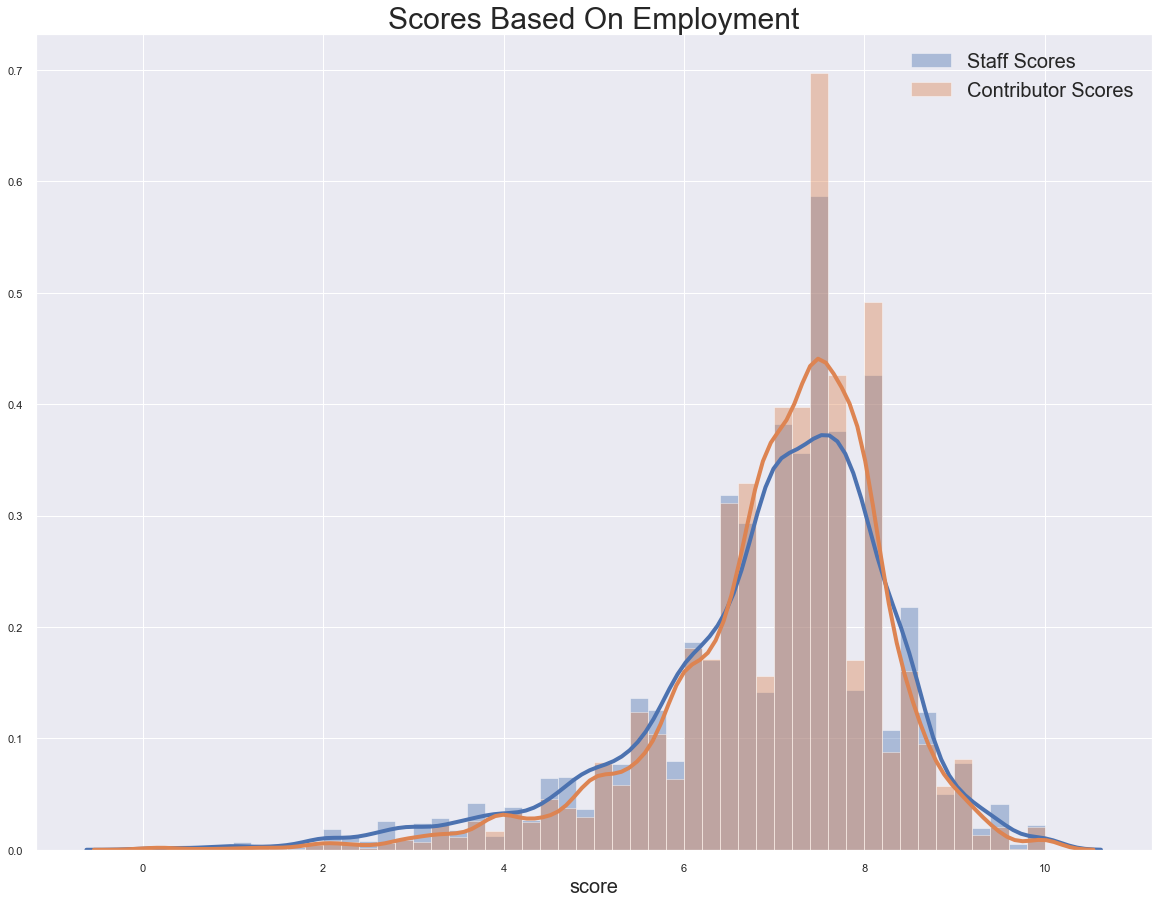

In [61]:
# Distributions of scores based on employment
plt.figure(figsize=(20,15));
sns.distplot(staff_df['score'], label = 'Staff Scores', kde_kws={'lw': 4});
sns.distplot(ns_sample_df['score'], label = 'Contributor Scores', kde_kws={'lw': 4});
plt.title('Scores Based On Employment', fontsize = 30)
plt.rcParams['axes.labelsize'] = 20
plt.legend(fontsize = 20)
#plt.show();
plt.savefig('Score_Staff.png', bbox_inches = 'tight')

The null hyothesis is that there is no significant difference in the mean score given by Pitchfork staff vs. freelance contributors

In [10]:
ns_sample_df.describe()

,reviewid,score,best_new_music,pub_weekday,pub_day,pub_month,pub_year
count,5759.000000,5759.000000,5759.000000,5759.000000,5759.000000,5759.000000,5759.000000
mean,13642.542108,7.046866,0.053655,2.125716,15.381316,6.271749,2009.696475
std,6085.010435,1.227084,0.225355,1.615044,8.765188,3.281663,4.376622
min,11.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1999.000000
25%,9575.500000,6.500000,0.000000,1.000000,8.000000,3.000000,2006.000000
50%,14633.000000,7.300000,0.000000,2.000000,15.000000,6.000000,2010.000000
75%,18732.500000,7.800000,0.000000,3.000000,23.000000,9.000000,2013.000000
max,22721.000000,10.000000,1.000000,6.000000,31.000000,12.000000,2017.000000


In [11]:
staff_df.describe()

,reviewid,score,best_new_music,pub_weekday,pub_day,pub_month,pub_year
count,5759.000000,5759.000000,5759.000000,5759.000000,5759.000000,5759.000000,5759.000000
mean,9528.404584,6.924848,0.047057,2.111130,15.742664,6.305956,2006.457892
std,5899.214741,1.413286,0.211779,1.696229,8.753153,3.363497,4.392033
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1999.000000
25%,4741.500000,6.300000,0.000000,1.000000,8.000000,3.000000,2003.000000
50%,9234.000000,7.200000,0.000000,2.000000,16.000000,6.000000,2006.000000
75%,13238.000000,7.800000,0.000000,3.000000,23.000000,9.000000,2009.000000
max,22745.000000,10.000000,1.000000,6.000000,31.000000,12.000000,2017.000000


In [12]:
stats.ttest_ind(staff_df['score'], ns_sample_df['score'], equal_var = False)

Ttest_indResult(statistic=-4.947313632069325, pvalue=7.632903047924309e-07)

In [13]:
t_stat = -4.9473

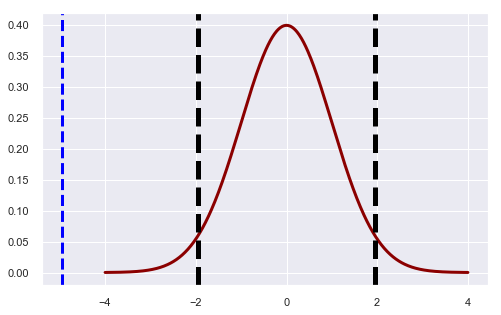

In [14]:
# Visualization function copied from learn.co to see the critical values and where the p-score falls 

def visualize_t(t_stat, n_control, n_experimental):
    
    """
    Visualize the critical t values on a t distribution
    
    Parameters
    -----------
    t-stat: float
    n_control: int
    n_experiment: int
    
    Returns
    ----------
    None
    
    """
    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.ppf to get critical value. For alpha = 0.05 and two tailed test
    crit = stats.t.ppf(1-0.025, (n_control+n_experimental-2))
    tstat=t_stat
    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(crit, color='black', linestyle='--', lw=5)
    ax.axvline(-crit, color='black', linestyle='--', lw=5)
    ax.axvline(tstat, color='blue', linestyle='--', lw=3 )
    plt.show()
    return None

# n_control = len(control)
# n_experimental = len(experimental)
visualize_t(t_stat, len(staff_df['score']), len(ns_sample_df['score']))

The p-value indicates that there is a statistically significant difference between Staff and Non-staff scores, however the real world impact would be negligible if noticeable at all. The difference in mean score is less than .1, nothing anyone without a statistical lean would notice.

# Does length of review give an indication of score?

In [15]:
# Limit dataframe to the scores and the reviews themselves
used_cols = ['score', 'content']
review_df = df[used_cols]
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18389 entries, 0 to 24956
Data columns (total 2 columns):
score      18389 non-null float64
content    18389 non-null object
dtypes: float64(1), object(1)
memory usage: 431.0+ KB


In [16]:
# Parse the reviews into word counts (not exact, does not account for special characters/non-words)
review_df['word_count'] = review_df['content'].str.count(' ') + 1

In [17]:
# New dataframe
review_df.describe()

,score,word_count
count,18389.000000,18389.000000
mean,7.005715,703.001686
std,1.293758,259.018590
min,0.000000,1.000000
25%,6.400000,530.000000
50%,7.200000,648.000000
75%,7.800000,817.000000
max,10.000000,3678.000000


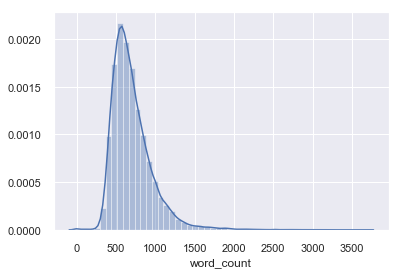

In [18]:
# Quick visual look at the word count distribution
sns.distplot(review_df['word_count'])

In [19]:
# Categorizing reviews as "short = 0", "medium = 1", and "long = 2" based on mean of the word counts
review_df.loc[review_df['word_count'] >= 817, "length" ] = 2
review_df.loc[review_df['word_count'] <= 530, "length" ] = 0
review_df.loc[(review_df['word_count'] < 817) & (review_df['word_count'] > 530), "length" ] = 1

In [20]:
review_df.head()

,score,content,word_count,length
0,9.3,"“Trip-hop” eventually became a ’90s punchline,...",1432,2.0
1,7.9,"Eight years, five albums, and two EPs in, the ...",416,0.0
2,7.3,Minneapolis’ Uranium Club seem to revel in bei...,589,1.0
4,9.0,Kleenex began with a crash. It transpired one ...,1155,2.0
6,8.1,It is impossible to consider a given release b...,526,0.0


In [21]:
# Making new dataframes to work with
short_df = review_df[review_df['length'] == 0]
mid_df = review_df[review_df['length'] == 1]
long_df = review_df[review_df['length'] == 2]

In [22]:
short_df.describe()

,score,word_count,length
count,4617.000000,4617.000000,4617.0
mean,6.786983,453.374052,0.0
std,1.074178,62.183944,0.0
min,0.000000,1.000000,0.0
25%,6.300000,421.000000,0.0
50%,7.000000,464.000000,0.0
75%,7.500000,500.000000,0.0
max,10.000000,530.000000,0.0


In [23]:
long_df.describe()

,score,word_count,length
count,4603.000000,4603.000000,4603.0
mean,7.355507,1045.595047,2.0
std,1.546026,259.602847,0.0
min,0.000000,817.000000,2.0
25%,6.700000,878.000000,2.0
50%,7.700000,967.000000,2.0
75%,8.400000,1120.500000,2.0
max,10.000000,3678.000000,2.0


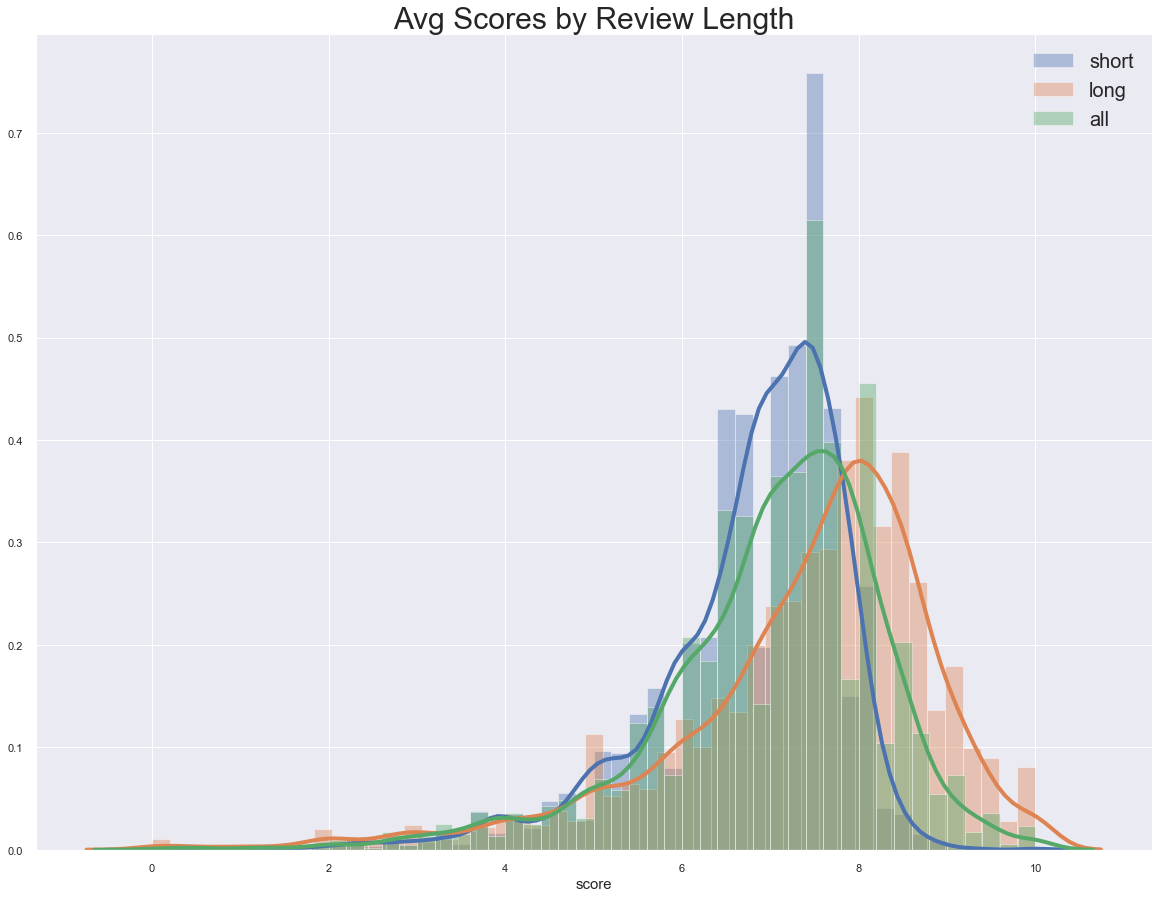

In [60]:
# Visualizing the means of the short and long reviews against the population mean
plt.figure(figsize=(20,15))
sns.distplot(short_df['score'], label = 'short', kde_kws={'lw': 4})
sns.distplot(long_df['score'], label = 'long', kde_kws={'lw': 4})
sns.distplot(review_df['score'].sample(n=4600, random_state=87), label = 'all', kde_kws={'lw': 4})
plt.title('Avg Scores by Review Length', fontsize = 30)
plt.legend(fontsize = 20)
plt.rcParams['axes.labelsize']= 20
plt.savefig('AVGScore_Length.png', bbox_inches = 'tight')

In [25]:
# Running t-test 
print(stats.ttest_ind(long_df['score'], review_df['score'], equal_var = False))
print(stats.ttest_ind(short_df['score'], review_df['score'], equal_var = False))

Ttest_indResult(statistic=14.159273633640558, pvalue=7.91126816411023e-45)
Ttest_indResult(statistic=-11.846114814970448, pvalue=4.082182165770465e-32)


Both short and long review p-scores indicate a statistically significant deviation from the population mean, supported by summary stats: Pop Mean ~ 7, Short Mean ~ 6.78, Long Mean ~ 7.36

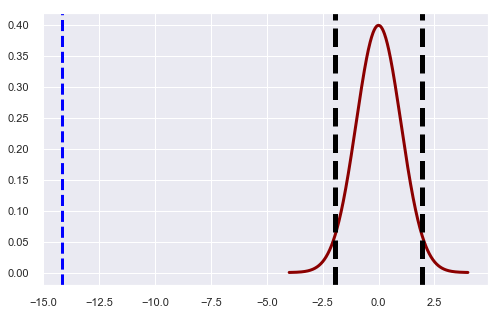

In [26]:
visualize_t(-14.16, len(short_df['score']), len(review_df['score']))

In [27]:
short_df.to_csv('short_reviews.csv')

In [28]:
long_df.to_csv('long_reviews.csv')

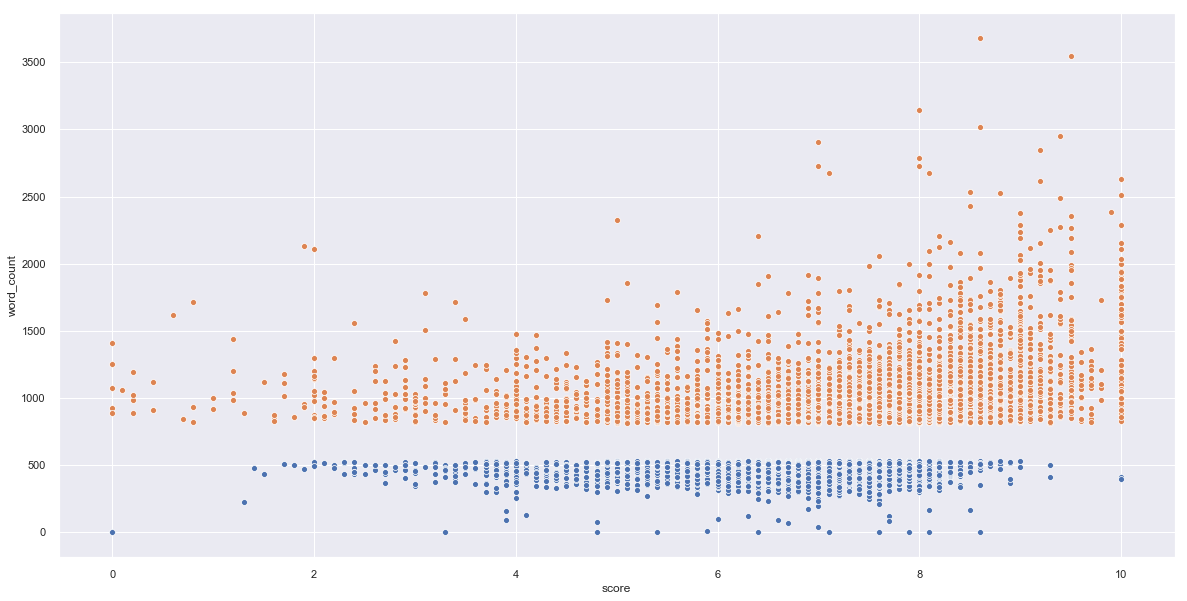

In [29]:
plt.figure(figsize = (20, 10))
sns.scatterplot(short_df['score'], short_df['word_count'])
sns.scatterplot(long_df['score'], long_df['word_count'])
plt.show()

# Looking for other correlations

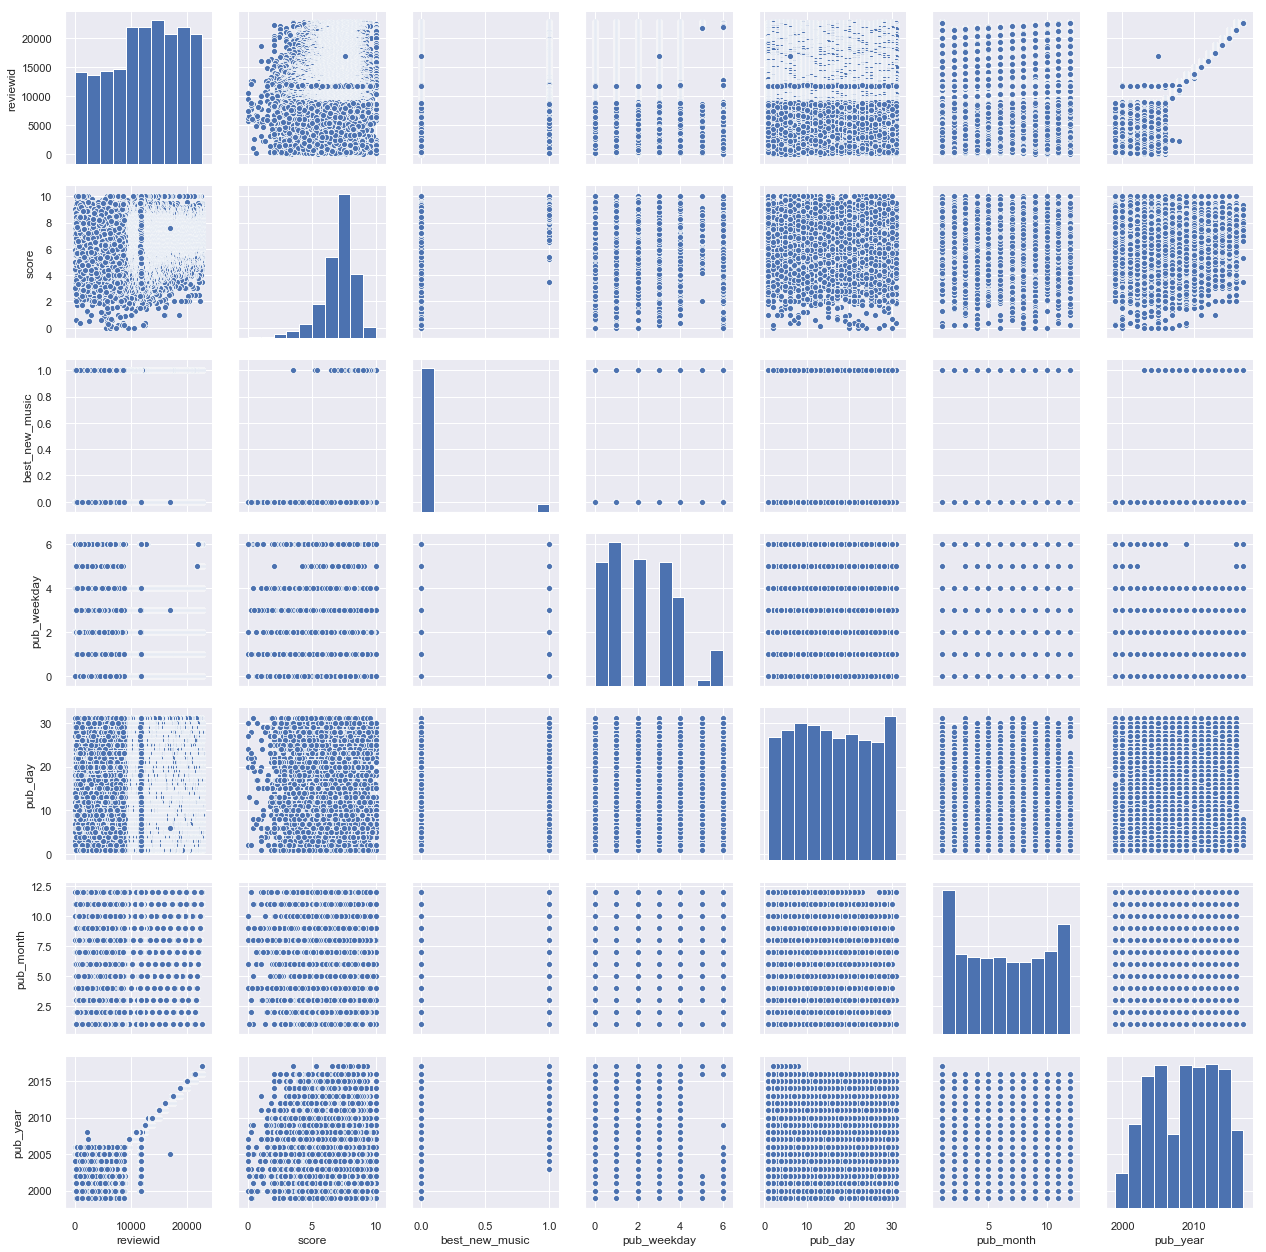

In [30]:
sns.pairplot(df)

### Fruitless attempt to find differences between staff and contractor review scores based on length

In [31]:
lastdf = df[[ 'reviewid','score', 'content', 'author_type']]
lastdf['word_count'] = lastdf['content'].str.count(' ') + 1
lastdf.loc[lastdf['word_count'] >= 817, "length" ] = 2
lastdf.loc[lastdf['word_count'] <= 530, "length" ] = 0
lastdf.loc[(lastdf['word_count'] < 817) & (lastdf['word_count'] > 530), "length" ] = 1

In [32]:
lastdf.head()

,reviewid,score,content,author_type,word_count,length
0,22703,9.3,"“Trip-hop” eventually became a ’90s punchline,...",contributor,1432,2.0
1,22721,7.9,"Eight years, five albums, and two EPs in, the ...",contributor,416,0.0
2,22659,7.3,Minneapolis’ Uranium Club seem to revel in bei...,contributor,589,1.0
4,22661,9.0,Kleenex began with a crash. It transpired one ...,associate reviews editor,1155,2.0
6,22725,8.1,It is impossible to consider a given release b...,tracks coordinator,526,0.0


In [33]:
lastdf=lastdf.dropna(subset = ['author_type'])

In [34]:
lastdf['staff'] = ['NS' if 'contribut' in author else 'S' for author in lastdf['author_type']] 

In [36]:
lastdf.groupby(['staff','length']).mean()

reviewid     score   word_count
staff length                                     
NS    0.0     14436.500637  6.865691   453.936665
      1.0     13996.076282  6.975008   656.075024
      2.0     12076.937061  7.357444  1048.771246
S     0.0     12884.300000  6.617838   463.875676
      1.0     13383.246185  6.936826   654.037640
      2.0     13753.444223  7.753187  1075.878486